In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker

In [2]:
n = 1000
dim = 1

mean1 = tf.constant([[0.]])
mean2 = tf.constant([[8.]])
noise_mean = tf.constant([[6.]])

2022-05-11 16:08:37.762575: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-11 16:08:37.762610: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-05-11 16:08:37.762614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-05-11 16:08:37.762701: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-05-11 16:08:37.762721: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-05-11 16:08:37.762725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-05-11 16:08:37.763476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

# All modes

In [128]:
def t_log_prob(x, loc, nv):
    dim = x.shape[1]
    scale = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma = scale @ tf.transpose(scale)
    sigma_inv = tf.linalg.inv(sigma)
    
    x_c = tf.matmul(x - loc, sigma_inv, transpose_b=True) # n x dim
    x_c_norm_sq = tf.einsum(
      "ij,ij->i",
      x_c,
      x - loc) # n
    pp = -0.5 * (nv + dim) * tf.math.log(1 + x_c_norm_sq / nv)
    return pp

def t_score(x, loc, nv):
    dim = x.shape[1]
    scale = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma = scale @ tf.transpose(scale)
    sigma_inv = tf.linalg.inv(sigma)
    
    x_c = x - loc
    y = tf.matmul(x_c, sigma_inv, transpose_b=True) # n x dim
    y_norm_sq = tf.einsum(
      "ij,ij->i",
      y,
      x_c) # n
    factor = -0.5 * (nv + dim) / (1 + y_norm_sq / nv)
    grad = tf.expand_dims(factor, 1) * 2/nv * y
    return grad

def t_hess(x, loc, nv=7):
    dim = x.shape[1]
    scale = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma = scale @ tf.transpose(scale)
    sigma_inv = tf.linalg.inv(sigma)
    
    x_c = x - loc # n x dim
    y = tf.matmul(x_c, sigma_inv, transpose_b=True) # n x dim
    y_norm_sq = tf.einsum("ij,ij->i", y, x_c) # n
    factor1 = tf.expand_dims(-0.5 * (nv + dim) / (1 + y_norm_sq / nv), axis=1) # n x 1
    term1 = 2/nv * tf.expand_dims(factor1, axis=-1) * tf.expand_dims(sigma_inv, axis=0) # n x dim x dim
    
    factor2 = tf.expand_dims(
        tf.expand_dims(0.5 * (nv + dim) / (1 + y_norm_sq / nv)**2, axis=1),
        axis=1
    ) # n x 1 x 1
    outer = tf.expand_dims(x_c, axis=-1) @ tf.expand_dims(x_c, axis=1) # n x dim x dim

    term2 = 4/nv**2 * factor2 * tf.expand_dims(sigma_inv @ sigma_inv, axis=0) @ outer # n x dim x dim
    
    hess = term1 + term2
    return hess


def t_hess_auto(xx, loc):
    xx = tf.stack(mode_list, axis=0)

    with tf.GradientTape() as g2:
        g2.watch(xx)
        with tf.GradientTape() as g1:
            g1.watch(xx)
            pp = t_log_prob(xx, loc[0])
        gg = g1.gradient(pp, xx)
    gg2 = tf.reduce_sum(g2.jacobian(gg, xx), axis=2)
    
    return gg2

In [3]:
tf.random.set_seed(1)

In [4]:
dim = 1

## mixure of gaussians
k = 1
delta = 8.
ratio_sample = 1.
ratio_target = 0.5

target, log_prob_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
    dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

## RBM
# dh = 2
# c_off = tf.concat([tf.ones(2) * 1., tf.zeros(dh-2)], axis=0)
# target, log_prob_fn = models.create_rbm(c=0., dx=dim, dh=dh, burnin_number=2000, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_rbm(c=c_off, dx=dim, dh=dh, burnin_number=2000, return_logprob=True)


## t-banana
# nmodes = 20
# nbanana = 10
# ratio_s_var = 5.

# ratio_target = [1/nmodes] * nmodes

# random_weights = tf.exp(tf.random.normal((nmodes,)) * ratio_s_var)
# ratio_sample = random_weights / tf.reduce_sum(random_weights)
# ratio_sample = tf.constant([7.7579454e-05, 4.8678854e-01, 1.9621593e-05, 8.5506955e-04, 6.4088061e-02,
#  3.0733529e-05, 8.0045894e-02, 8.6801274e-06, 6.5268621e-02, 1.0864044e-03,
#  8.0379490e-05, 1.7575960e-04, 7.1048180e-06, 2.5154607e-04, 7.9203119e-06,
#  3.1107475e-04, 6.7057749e-06, 3.7424570e-08, 2.0604947e-01, 9.4840795e-02,])
# print("ratio sample:", ratio_sample.numpy())

# loc = tfp.distributions.Uniform(low=-tf.ones((dim,))*10, high=tf.ones((dim,))*10).sample(nmodes) # uniform in [-20, 20]^d
# # loc = tf.constant([[1.] * dim, [-1.] * dim])
# loc = tf.constant([[  4.363884,   15.967144 ],
#  [-19.275364,   16.7435   ],
#  [ -9.249988,   11.599079 ],
#  [  1.3244209, -15.977497 ],
#  [ -6.122322,   19.227615 ],
#  [  3.3140602, -19.436832 ],
#  [ -3.0468788,   2.5974464],
#  [ -7.928982,   -3.2911835],
#  [  9.438709,    4.6570053],
#  [ 15.773956,  -11.664844 ],
#  [  8.781576,  -13.424449 ],
#  [ -5.3023624,  -2.2030296],
#  [ -7.5855064,   1.1301193],
#  [ 11.219397,    5.4884872],
#  [ 11.858902,   -2.2964   ],
#  [  5.84301,    19.939896 ],
#  [ 10.34234,     5.44598  ],
#  [-19.316349,    5.493574 ],
#  [ -3.2042732,  13.097462 ],
#  [-16.813465,   12.329731 ]])
# print("means", loc)

# b = 0.003 # 0.03
# target, log_prob_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, b=b,
#     nbanana=nbanana, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_sample, loc=loc, b=b,
#     nbanana=nbanana, return_logprob=True)


## t-mixture
# nmodes = 3
# t_std = .1
# ratio_s_var = 1.

# ratio_target = [1/nmodes] * nmodes

# random_weights = tf.exp(tf.random.normal((nmodes,)) * ratio_s_var)
# ratio_sample = random_weights / tf.reduce_sum(random_weights)
# print("ratio sample:", ratio_sample.numpy())

# loc = tf.constant([[5.] * dim, [-5.] * dim, [5, -5]])
# print("means", loc)

# target, log_prob_fn = models.create_mixture_t(dim=dim, ratio=ratio_target, loc=loc, std=t_std,
#     return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_t(dim=dim, ratio=ratio_sample, loc=loc, std=t_std,
#     return_logprob=True)


## scaled Gaussian 
# ratio_t = 0.5
# ratio_s = 0.3
# target, log_prob_fn = models.create_mixture_gaussian_scaled(ratio=ratio_t, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_scaled(ratio=ratio_s, return_logprob=True)

In [5]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

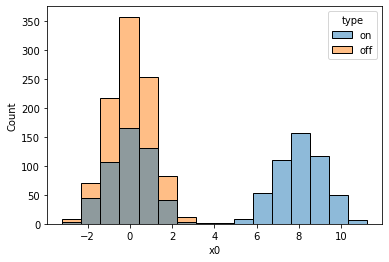

In [6]:
# _ = sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")
# # _ = plt.axis(xmax=10., xmin=-10., ymax=10., ymin=-10.)

_ = sns.histplot(data=samples_df, x="x0", hue="type")

In [7]:
ntrain = n // 2
threshold = 1.

samples_init = samples_off
# samples_init = samples_on

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

# start_pts = sample_off_train
start_pts = tf.concat([
    sample_off_train[:(ntrain//2)], 
    tf.random.uniform(shape=(ntrain//2, dim), minval=-10., maxval=10.)], axis=0)

mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold, max_iterations=200)

In [8]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  <tf.Tensor: shape=(1,), dtype=float32, numpy=array([8.], dtype=float32)>],
 [<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>,
  <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>])

In [46]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [47]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [48]:
std = [1., .9, 1.286, 1.29]

In [49]:
T = 10

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=sample_off_train, ind_pair_list=ind_pair_list, **proposal_dict)

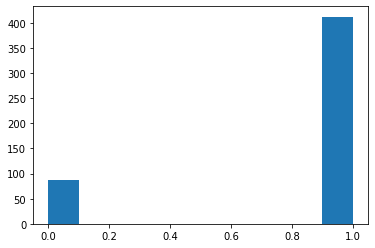

In [50]:
if len(mh.if_accept.shape) == 3:
    xx = (np.sum(mh.if_accept.numpy()[-1], axis=0) > 0.).astype(np.float32)
else:
    xx = (np.sum(mh.if_accept.numpy(), axis=0) > 0.).astype(np.float32)
_ = plt.hist(xx)

In [51]:
if len(mh.if_accept.shape) == 3:
    x_all = mh.x[-1] #!
else:
    x_all = mh.x
    
x_0 = x_all[0].numpy()
x_t = x_all[-1].numpy()

if dim == 1:
    x_0 = np.expand_dims(x_0, -1)
    x_t = np.expand_dims(x_t, -1)

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "Before"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "After"

sample_on_df = pd.DataFrame({f"x{i}": samples_on.numpy()[:x_0.shape[0], i] for i in range(dim)})
sample_on_df["type"] = "Target"

x0_df = pd.concat([x0_df, sample_on_df], ignore_index=True)
xt_df = pd.concat([xt_df, sample_on_df], ignore_index=True)


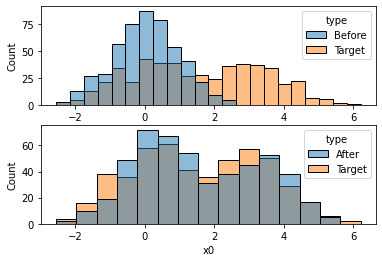

In [53]:
# # fig = plt.figure(figsize=(14, 5))
# _ = sns.jointplot(data=x0_df, x="x0", y="x1", hue="type",
# #                   xlim=(-4., 10.), 
# #                   ylim=(-7, 7),
#  )

# _ = sns.jointplot(data=xt_df, x="x0", y="x1", hue="type",
# #                   xlim=(-4., 10.), 
# #                   ylim=(-7, 7),
#  )

plt.subplot(2, 1, 1)
_ = sns.histplot(data=x0_df, x="x0", hue="type")
plt.subplot(2, 1, 2)
_ = sns.histplot(data=xt_df, x="x0", hue="type")

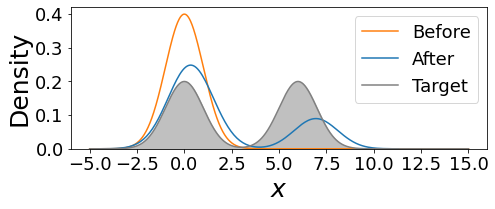

In [36]:
# only works for dim=1
xx = tf.reshape(tf.linspace(-5., 15., 1000), (-1, 1))

yy_sample = tf.exp(log_prob_off_fn(xx)) / tf.math.sqrt(2 * np.pi)
sample_df = pd.DataFrame({"x": xx[:, 0].numpy(), "prob": yy_sample.numpy(), "type": "Before"})

yy_sample_on = tf.exp(log_prob_fn(xx)) / tf.math.sqrt(2 * np.pi)
sample_on_df = pd.DataFrame({"x": xx[:, 0].numpy(), "prob": yy_sample_on.numpy(), "type": "Before"})

res_df = pd.concat([x0_df, xt_df, sample_on_df], ignore_index=True)

fig = plt.figure(figsize=(7, 3))
sns.lineplot(data=sample_df, x="x", y="prob",
            color="tab:orange",
            label="Before",
            )
sns.kdeplot(data=res_df.loc[res_df.type.isin(["After"])], x="x0", 
#             fill=True, 
            color="tab:blue",
            label="After"
            )
sns.lineplot(data=sample_on_df, x="x", y="prob",
             color="grey",
             label="Target",
            )
plt.fill_between(sample_on_df.x, sample_on_df.prob, color="silver")

plt.xlabel("$x$", fontsize=25)
plt.ylabel("Density", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
fig.savefig("figs/paper/bimodal_density_plot.pdf")

In [54]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [55]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

2022-05-10 15:42:13.075796: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [56]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.0 
after: 0.0


# Repeat experiment

In [11]:
def repeat_experiment(n, nrep, target_dist, sample_dist):
    jump_ls = tf.linspace(0.5, 1.5, 51)
    
    ntrain = n // 2
    threshold = 1.

    num_boot = 800
    alpha = 0.05
    T = 10
    
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n-ntrain)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    
    # generate samples
    off_sample_all = sample_dist.sample((nrep, n))

    p_val_list = []
    jump_ratio_list = []
    iterator = trange(nrep)
    for i in iterator:
        # sample data
        samples_init = off_sample_all[i, :]
        
        sample_init_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]
#         start_pts = sample_off_train
        start_pts = tf.concat([
            sample_init_train[:(ntrain//2)], 
            tf.random.uniform(shape=(ntrain//2, dim), minval=-10., maxval=10.)], axis=0)
        
        # find modes
        mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)
        off_sample = off_sample_all[i, :]
        
        proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)
        _, ind_pair_list = pairwise_directions(mode_list, return_index=True)

        # find best jump scale
        mh = MCMCKernel(log_prob=log_prob_fn)
        mh.run(steps=T, std=jump_ls, x_init=sample_init_train, ind_pair_list=ind_pair_list, **proposal_dict)

        # compute ksd
        scaled_ksd_vals = []
        for i in range(len(jump_ls)):
            iterator.set_description(f"Jump scale [{i+1} / {len(jump_ls)}]]")

            # run dynamic for T steps
            x_t = mh.x[i, -1]
            if len(x_t.shape) == 1: 
                x_t = tf.expand_dims(x_t, -1)
        
            # compute ksd
            _, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
            ksd_val = ksd_val

            scaled_ksd_vals.append(ksd_val)

        # get best jump scale
        best_jump = jump_ls[tf.math.argmax(scaled_ksd_vals)]
        best_proposal_dict = proposal_dict
        
        # mh perturbation
        mh = MCMCKernel(log_prob=log_prob_fn)
        mh.run(steps=T, std=best_jump, x_init=sample_off_test, 
               ind_pair_list=ind_pair_list, **proposal_dict)
        x_t = mh.x[-1]
        if len(x_t.shape) == 1: 
            x_t = tf.expand_dims(x_t, -1)
        
        # compute p-value
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=target_dist, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)

        multinom_one_sample = multinom_samples[i, :]

        _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)

        p_val_list.append(p_val)
        jump_ratio_list.append(best_jump.numpy())
        
    res = pd.DataFrame({"pval": p_val_list, "jump": jump_ratio_list})
    return res

In [12]:
res_df = repeat_experiment(n=n, nrep=100, target_dist=target, sample_dist=proposal_off)

  0%|          | 0/100 [00:00<?, ?it/s]

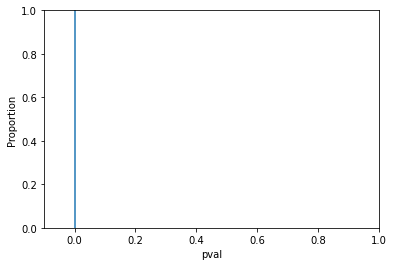

In [13]:
sns.ecdfplot(data=res_df, x="pval")
_ = plt.axis(xmin=-0.1, xmax=1.)

mean jump scale: 1.1520001


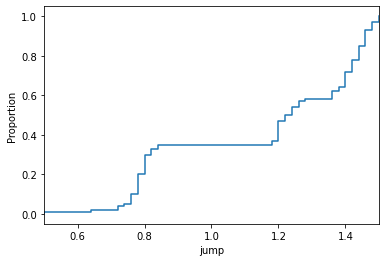

In [14]:
print("mean jump scale:", res_df.jump.mean())
sns.ecdfplot(data=res_df, x="jump")
_ = plt.axis(xmin=0.5, xmax=1.5, ymin=-0.05, ymax=1.05)

In [15]:
res_df_ordered = repeat_experiment(n=n//2, nrep=100, target_dist=target, sample_dist=target)

  0%|          | 0/100 [00:00<?, ?it/s]

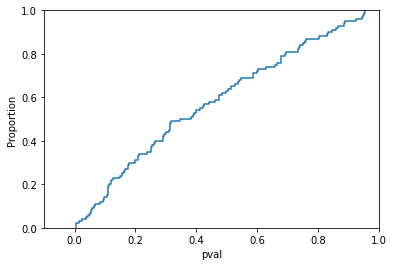

In [16]:
sns.ecdfplot(data=res_df_ordered, x="pval")
_ = plt.axis(xmin=-0.1, xmax=1.)